# Baseline

Here a baseline is defined as a reference point to beat with subsequent models. 

To do so, a validation method has to be fixed. In order to respect the format of the predictions requested, several folds will be made with an expanding window scheme, setting as prediction horizon 12 and step between folds 12. The first date to predict will be the second month. 

For the **evaluation** it is worth noting the following:
- The fold that will be most valued among models is the one corresponding to 2019, as there is enough history, it is similar to the previous year, so good results are expected in any model. 
- 2018 will not be considered for comparison because there is not enough history for the model to provide good results (as will be seen below) and also the data from previous years are not very similar. 
- 2020 cannot be considered either because they have been artificially adulterated (see EDA).
- However both 2018 and 2020 will be considered when evaluating just for the sake of curiosity and to detect potential unexpected behaviour.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.split import ExpandingWindowSplitter
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.statsforecast import StatsForecastAutoETS
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanSquaredError,
    MeanAbsolutePercentageError,
)
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.model_selection import ForecastingGridSearchCV

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [17]:
# Read train data
ts = pd.read_csv(
    "../data/processed_train.csv",  # data path
    index_col=[0],  # index column
    parse_dates=[0],  # parse date column
)

# Get training data
train_ts = ts.dropna()

# Assert time series dates consistency by checking all dates are monthly and recorded properly (this includes missing dates if any)
train_ts = train_ts.asfreq("MS").fillna(
    0
)  # if there are missing dates, they will be filled with 0

In [18]:
y = train_ts.copy()  # copy to avoid any changes to original data
y.index = pd.PeriodIndex(y.index, freq="M")  # required frequency from sktime

# Baselines

1. First, a list of commonly used baseline models will be defined in order to choose the best of them as a reference point. 
2. Then a grid search will be used to evaluate each of them with different metrics and the best one will be chosen. 
3. The folds of forecasts will be plotted to compare the performance of each model visually.

In [19]:
# FORECASTERS (BASELINES)

# Define all modes of naive baseline
naive_baselines = [
    (f"naive_{strategy}", NaiveForecaster(strategy=strategy, sp=12))
    for strategy in ["last", "mean", "drift"]
]

# Define a set of simple forecasters
forecasters = [
        ("theta", ThetaForecaster(sp=12)),
        ("exponential_smoothing", ExponentialSmoothing(trend="add", sp=12)),
        ("ets", StatsForecastAutoETS(season_length=12)),
        ("stl", STLForecaster(
            sp=12,
            forecaster_trend=NaiveForecaster(strategy="drift", sp=12),
            forecaster_seasonal=NaiveForecaster(strategy="last", sp=12),
        )),
    ]
forecasters.extend(naive_baselines) # add naive forecasters

# Store keys of forecasters
forecaster_model_names = [key for key, _ in forecasters]

Best model based on MeanSquaredError(): {'selected_forecaster': 'naive_last'}
Best model based on MeanAbsoluteError(): {'selected_forecaster': 'naive_last'}
Best model based on MeanAbsolutePercentageError(): {'selected_forecaster': 'naive_mean'}


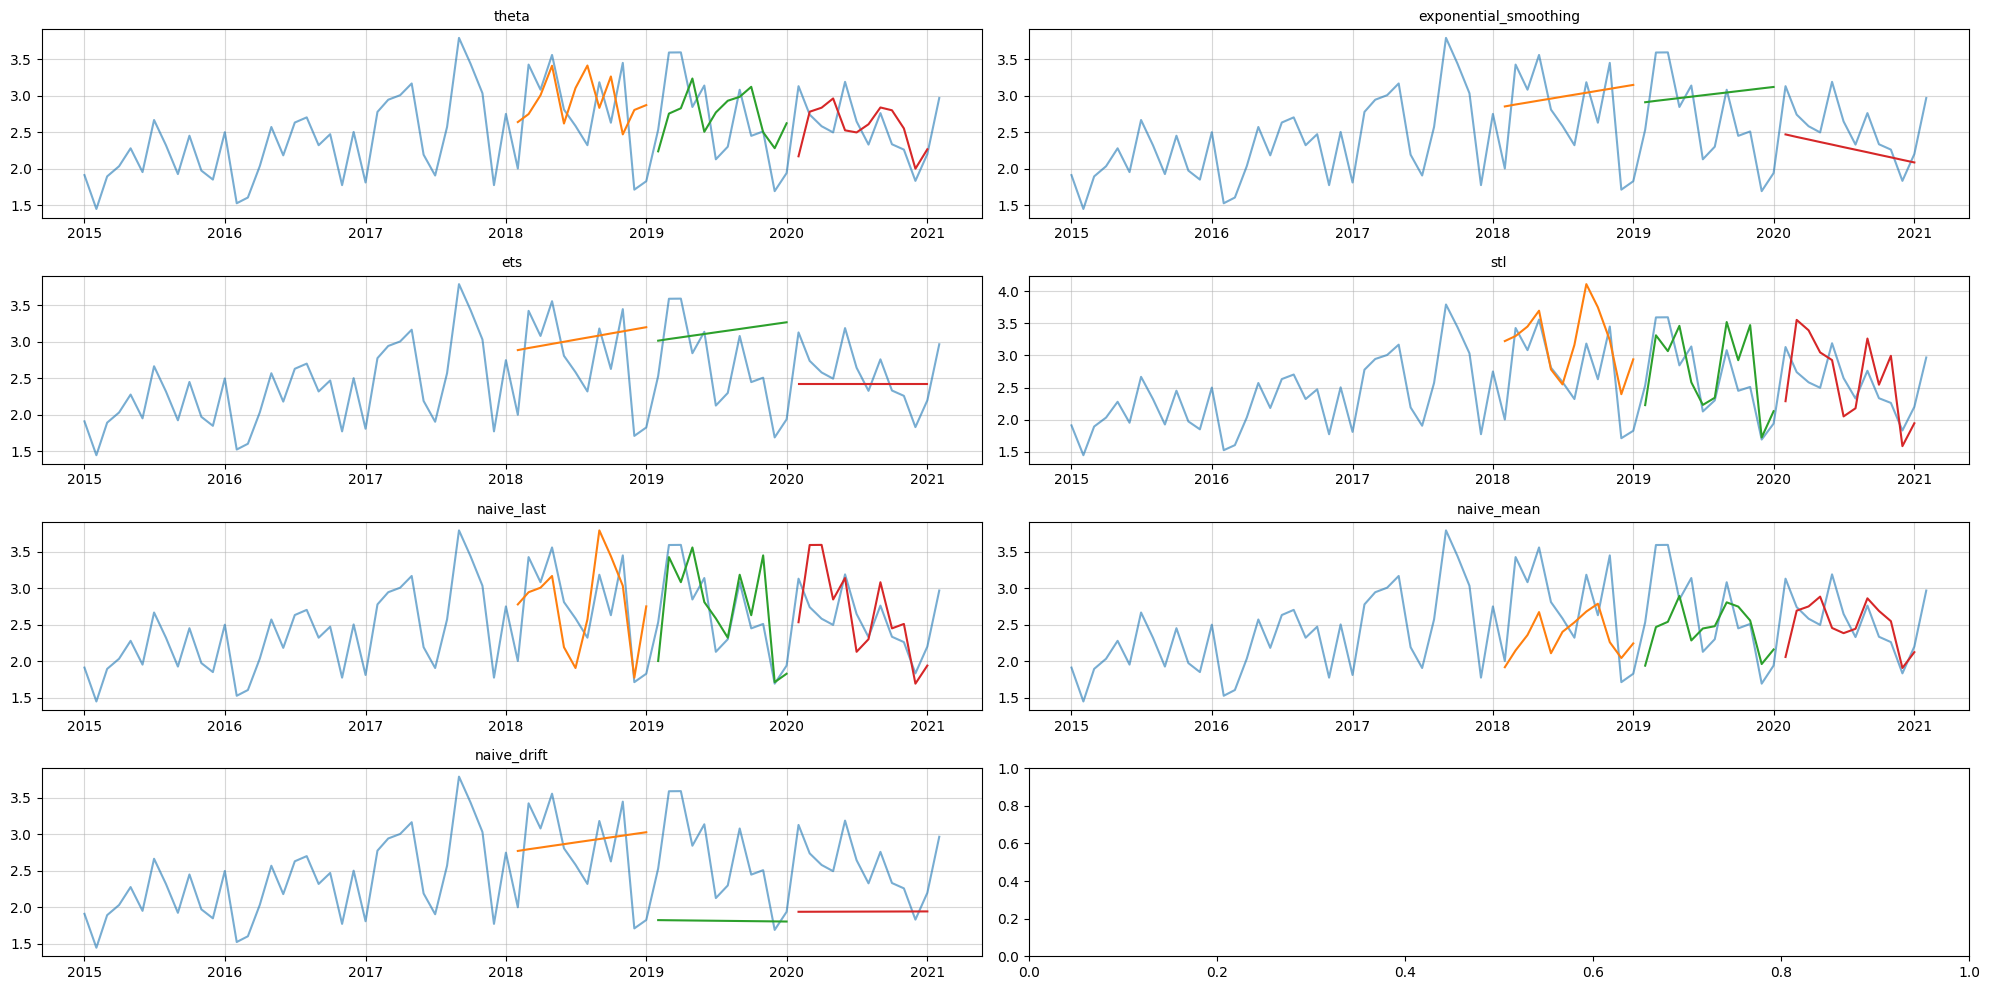

In [20]:
# GRID SEARCH OF BEST BASELINE MODEL

# Define time series cross validation)
cv = ExpandingWindowSplitter(initial_window=37, step_length=12, fh=np.arange(1, 13))

# Compare the performance of the above forecasters
forecaster = MultiplexForecaster(
    forecasters=forecasters
)

# Run grid search to get the best model 
for metric in [MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()]:
    gscv = ForecastingGridSearchCV(
        forecaster=forecaster,
        param_grid={"selected_forecaster": forecaster_model_names},
        cv=cv,
        scoring=metric
    )
    gscv.fit(y)
    print(f"Best model based on {metric}: {gscv.best_params_}")


# Plot forecasts for each split of cv
fig, axes = plt.subplots(4, 2, figsize=(20, 10))
axes = axes.flatten()

for i, (model_name, model) in enumerate(forecasters):
    axes[i].plot(train_ts.index, y.values, label="y", alpha=0.6)
    for train, test in cv.split(y):
        model = model.fit(y.iloc[train])
        y_pred_1 = model.predict(fh=y.iloc[test].index)
        axes[i].plot(train_ts.iloc[test].index, y_pred_1)
    axes[i].set_title(model_name, fontsize=10)
    axes[i].grid(alpha=0.5)
    
plt.tight_layout()
plt.show()

- The best model for the last three folds of data (2018, 2019, 2020) according to MSE and MAE is the NaiveForecaster based on repeating the last year of data. MAPE selects as best model the NaiveForecaster with mean strategy, but it can be see in the plot above that those forecasts are misising information. 
- Therefore, NaiveForecaster based on repeating the last year of data is selected as benchmark to be beaten by other models. This was expected (see EDA) as the patterns between 2018 and 2019 are similar. 

## Evaluation 

Finally, metrics are computed by fold and store as csv to compare them later against other models.

In [21]:
results_baseline = evaluate(
    forecaster=NaiveForecaster(strategy="last", sp=12),
    y=y,
    cv=cv,
    scoring=[
        MeanSquaredError(square_root=True),
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
    ],
)

results_baseline['model'] = 'baseline_naive_last'

# Export results
results_baseline.to_csv(
    "../data/evaluation.csv"
)

In [22]:
results_baseline

,test_MeanSquaredError,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,model
0,0.573653,0.507329,0.201105,0.002970,0.034698,37,2018-01,baseline_naive_last
1,0.441073,0.340174,0.127364,0.002210,0.102121,49,2019-01,baseline_naive_last
2,0.479795,0.374270,0.143973,0.003071,0.026912,61,2020-01,baseline_naive_last
